In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp '/content/kaggle.json' ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download adhoppin/blood-cell-detection-datatset/

 42% 5.00M/11.8M [00:00<00:00, 35.1MB/s]
100% 11.8M/11.8M [00:00<00:00, 70.8MB/s]


In [ ]:
! unzip /content/blood-cell-detection-datatset.zip -d '/content'

Archive:  /content/blood-cell-detection-datatset.zip
  inflating: /content/LICENSE        
  inflating: /content/README.dataset.txt  
  inflating: /content/README.md      
  inflating: /content/data.yaml      
  inflating: /content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg  
  inflating: /content/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg  
  inflating: /content/test/images/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg  
  inflating: /content/test/images/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg  
  inflating: /content/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg  
  inflating: /content/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg  
  inflating: /content/test/images/BloodImage_00113_jpg.rf.a17463f1ddc2e7729f935f8a74bc86a4.jpg  
  inflating: /content/test/images/BloodImage_00120_jpg.rf.6725d54bf5615683448eb1de4c7577ee.jpg  
  inflating: /

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [ ]:
import yaml
from ultralytics import YOLO

import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pathlib
%matplotlib inline
from collections import Counter

In [ ]:
!cat ../content/data.yaml

train: ../train/images
val: ../valid/images

nc: 3
names: ['Platelets', 'RBC', 'WBC']

In [ ]:
ls -1 ../content/train/images | wc -l

765


In [ ]:
# Load the YAML file
with open('../content/data.yaml', 'r') as f:
    data_yaml = yaml.safe_load(f)

# update YAML with absolute path to kaggle data.
data_yaml['train'] = '/content/train/images'
data_yaml['val'] = '/content/valid/images'

# write to disk
with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

In [ ]:
data_dir = Path("../content/")
images_dir = data_dir / "train" / "images"
labels_dir = data_dir / "train" / "labels"

class_names = data_yaml['names']

# Read the image file paths and annotations
image_paths = list(images_dir.glob("*.jpg"))
label_paths = sorted(labels_dir.glob("*.txt"))

In [ ]:
resolutions = []

for image_path in image_paths:
    img = cv2.imread(str(image_path))
    h, w, _ = img.shape
    resolutions.append((w, h))

unique_resolutions = set(resolutions)
print("Unique resolutions:", unique_resolutions)

Unique resolutions: {(416, 416)}


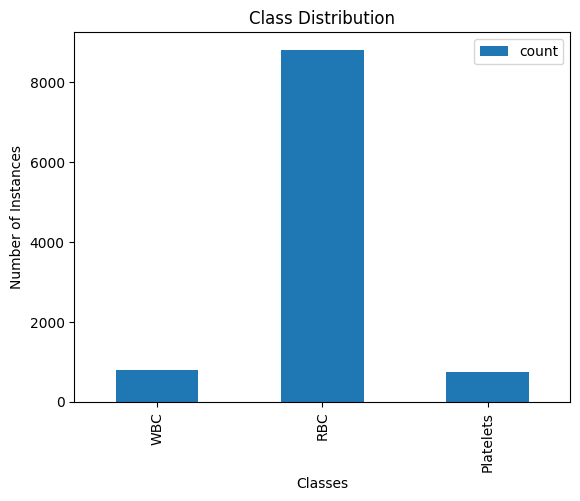

In [ ]:
class_counts = Counter()
for label_file in label_paths:
    with open(label_file, "r") as file:
        lines = file.readlines()
    class_counts.update(Counter([int(line.split()[0]) for line in lines]))

# Replace class IDs with class names
class_counts_names = {class_names[int(class_id)]: count for class_id, count in class_counts.items()}

# Create a pandas DataFrame and plot the bar chart
df = pd.DataFrame.from_dict(class_counts_names, orient="index", columns=["count"])
ax = df.plot(kind="bar")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution")
plt.show()

In [ ]:
data = []

for file in label_paths:
    with open(file) as f:
        lines = f.readlines()
        num_lines = len(lines)
        unique_values = len(set(list(map(lambda x: x.split()[0], lines))))

        data.append([file, num_lines, unique_values])

df = pd.DataFrame(data, columns=['file', 'num_lines', 'unique_values'])

<Axes: >

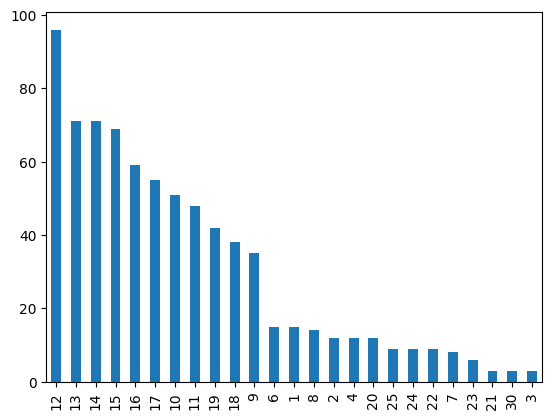

In [ ]:
# distribution of number of detections in an image
df['num_lines'].value_counts().plot(kind='bar')

<Axes: >

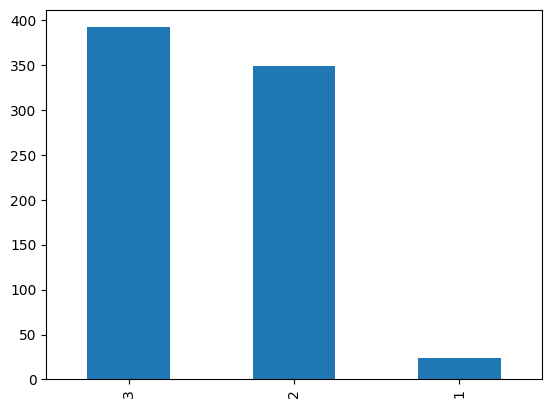

In [ ]:
# distribution of number of unique classes in images
df['unique_values'].value_counts().plot(kind='bar')

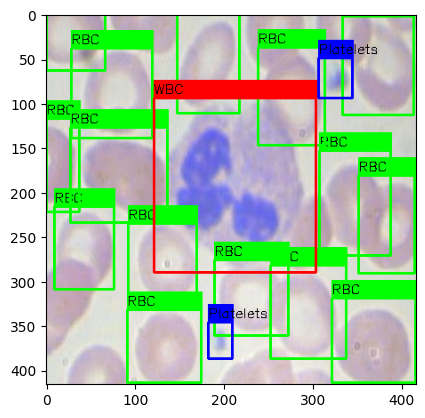

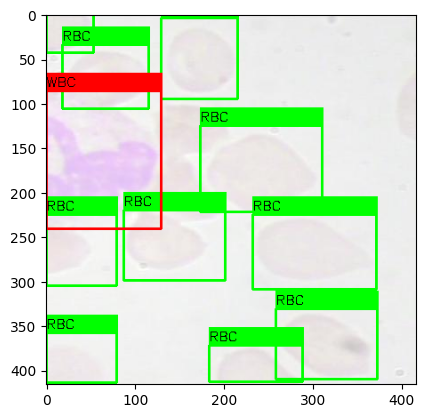

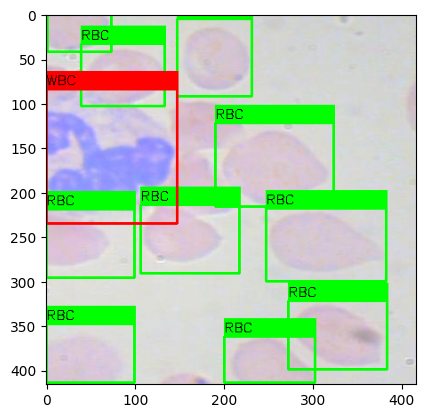

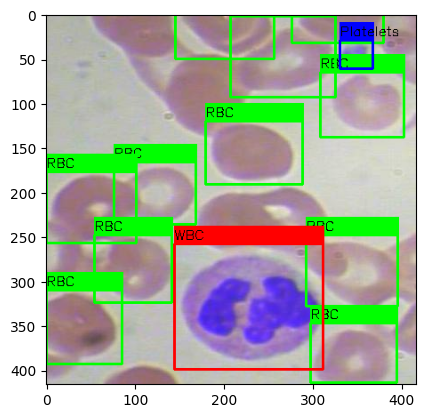

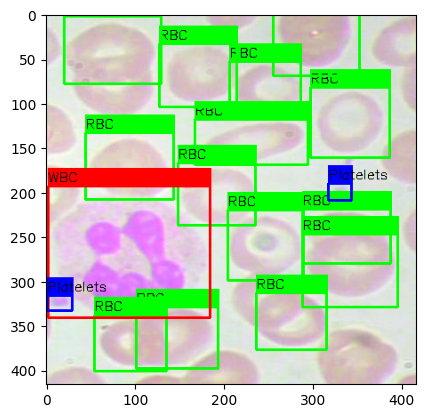

In [ ]:
# Number of images to randomly select
num_images = 5

# Get the list of all image files in the 'images' directory
image_files = [f for f in pathlib.Path(images_dir).iterdir() if f.is_file()]

# Shuffle the list of image files
random.shuffle(image_files)

# Select the specified number of image files
selected_image_files = image_files[:num_images]

for selected_image_file in selected_image_files:
    demo_image = selected_image_file
    # Get the corresponding label file
    demo_label = pathlib.Path(labels_dir) / f"{selected_image_file.stem}.txt"

    # Load the image using OpenCV's imread function
    image = cv2.imread(str(demo_image))

    # Get the list of class names from the 'data' dictionary
    class_list = data_yaml['names']

    # Define a list of colors to be used to draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Get the height and width of the image
    height, width, _ = image.shape

    # Create an empty list T
    T = []

    # Open the label file 'demo_label' in read mode and process each line
    with open(demo_label, "r") as file1:
        for line in file1.readlines():
            # Split the line into a list of strings
            split = line.split(" ")

            # Get the class id from the first element of the split list
            class_id = int(split[0])

            # Get the color corresponding to the class id from the 'colors' list
            color = colors[class_id]
            clazz = class_list[class_id]

            # Get the x, y, w, h bounding box coordinates from the split list
            x, y, w, h = float(split[1]), float(split[2]), float(split[3]), float(split[4])

            # Rescale the x, y, w, h values to the size of the image
            box = [int((x - 0.5*w)* width), int((y - 0.5*h) * height), int(w*width), int(h*height)]

            # Draw a rectangle on the image using the 'box' and 'color' values
            cv2.rectangle(image, box, color, 2)

            # Draw a filled rectangle for the class label on the image
            cv2.rectangle(image, (box[0], box[1] - 20), (box[0] + box[2], box[1]), color, -1)

            # Write the class label on the image
            cv2.putText(image, class_list[class_id], (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, .5, (0,0,0))

        # Show the image using matplotlib
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        # Optionally resize the image (commented out in code)
        image = cv2.resize(image, (600, 600))
        plt.show()

In [ ]:
# # clone YOLOv5 repository
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# %cd yolov5
# !git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

In [ ]:
model = YOLO('yolov5n.pt')
results = model.train(data='/content/data.yaml', epochs=30, batch=8)

PRO TIP 💡 Replace 'model=yolov5n.pt' with new 'model=yolov5nu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



100%|██████████| 5.27M/5.27M [00:00<00:00, 80.8MB/s]


Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5n.pt, data=/content/data.yaml, epochs=30, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, ke

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1760  ultralytics.nn.modules.conv.Conv             [3, 16, 6, 2, 2]              
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      4800  ultralytics.nn.modules.block.C3              [32, 32, 1]                   
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     29184  ultralytics.nn.modules.block.C3              [64, 64, 2]                   
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  3    156928  ultralytics.nn.modules.block.C3              [128, 128, 3]                 
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 71.9MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 765 images, 0 backgrounds, 0 corrupt: 100%|██████████| 765/765 [00:00<00:00, 1974.13it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 1117.75it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.26G      1.435      2.173      1.477         66        640: 100%|██████████| 96/96 [00:25<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]

                   all         73        967      0.686      0.858      0.849      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.33G      1.269      1.242      1.339         96        640: 100%|██████████| 96/96 [00:24<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.81it/s]

                   all         73        967      0.835      0.889      0.888      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.25G      1.241      1.149      1.302        109        640: 100%|██████████| 96/96 [00:20<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]

                   all         73        967      0.781      0.892      0.887      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.28G      1.228      1.087      1.294         54        640: 100%|██████████| 96/96 [00:20<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]

                   all         73        967      0.797      0.884      0.892      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      1.29G       1.23      1.069      1.282        113        640: 100%|██████████| 96/96 [00:29<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]

                   all         73        967      0.783        0.9      0.898      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.25G      1.201      1.027      1.273         68        640: 100%|██████████| 96/96 [00:27<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.82it/s]

                   all         73        967      0.775      0.891      0.879      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.22G      1.187       1.01      1.273        103        640: 100%|██████████| 96/96 [00:22<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.66it/s]

                   all         73        967        0.8        0.9      0.911      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.27G      1.168     0.9638      1.246        125        640: 100%|██████████| 96/96 [00:22<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]

                   all         73        967      0.876      0.904      0.909        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.26G      1.166     0.9682      1.254         74        640: 100%|██████████| 96/96 [00:22<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.33it/s]

                   all         73        967       0.85      0.932      0.918      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.27G      1.156     0.9414      1.238        139        640: 100%|██████████| 96/96 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.56it/s]

                   all         73        967      0.827      0.928      0.902      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.32G      1.158      0.913      1.241         84        640: 100%|██████████| 96/96 [00:22<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.08it/s]

                   all         73        967      0.824      0.907      0.898      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      1.28G      1.146     0.9145      1.229         90        640: 100%|██████████| 96/96 [00:20<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.05it/s]

                   all         73        967      0.823      0.928      0.897      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.28G      1.136     0.8947      1.225        112        640: 100%|██████████| 96/96 [00:21<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]

                   all         73        967      0.851      0.895      0.905      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.27G      1.137     0.8824      1.221        115        640: 100%|██████████| 96/96 [00:19<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.36it/s]

                   all         73        967      0.771      0.882      0.883       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.26G      1.132     0.8749      1.215         80        640: 100%|██████████| 96/96 [00:22<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]

                   all         73        967      0.843      0.913      0.908      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.27G      1.121     0.8687      1.211         97        640: 100%|██████████| 96/96 [00:20<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.27it/s]

                   all         73        967      0.857      0.913      0.907       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       1.3G      1.107     0.8454      1.202        121        640: 100%|██████████| 96/96 [00:22<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.18it/s]

                   all         73        967      0.846      0.936      0.914      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.38G      1.116     0.8596      1.206         96        640: 100%|██████████| 96/96 [00:20<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.92it/s]

                   all         73        967      0.844      0.935       0.91      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.28G      1.101     0.8412      1.203        122        640: 100%|██████████| 96/96 [00:21<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]

                   all         73        967      0.846      0.931      0.921      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.25G      1.092     0.8277      1.195         95        640: 100%|██████████| 96/96 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

                   all         73        967      0.857      0.924      0.919      0.627


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.36G      1.096     0.8119      1.221         61        640: 100%|██████████| 96/96 [00:21<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  5.24it/s]

                   all         73        967       0.86      0.895      0.905      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.22G      1.088     0.8104      1.216         66        640: 100%|██████████| 96/96 [00:18<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.95it/s]

                   all         73        967      0.856      0.907      0.913      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.22G      1.084      0.787      1.206         63        640: 100%|██████████| 96/96 [00:17<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.06it/s]

                   all         73        967       0.87      0.897       0.92       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.22G       1.07     0.7766      1.206         73        640: 100%|██████████| 96/96 [00:19<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

                   all         73        967      0.868      0.913      0.916      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.22G      1.056     0.7649        1.2         77        640: 100%|██████████| 96/96 [00:17<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.25it/s]

                   all         73        967      0.856      0.928      0.925      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.22G      1.054      0.756      1.196         40        640: 100%|██████████| 96/96 [00:17<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.50it/s]

                   all         73        967      0.849      0.936      0.923      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.23G      1.053      0.761      1.197         61        640: 100%|██████████| 96/96 [00:19<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  3.94it/s]

                   all         73        967      0.856      0.926      0.928      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.22G      1.048     0.7394      1.184         65        640: 100%|██████████| 96/96 [00:17<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.33it/s]

                   all         73        967       0.87      0.907      0.926      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.22G      1.042     0.7334      1.178         65        640: 100%|██████████| 96/96 [00:17<00:00,  5.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]

                   all         73        967      0.883      0.911      0.929      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.22G      1.035     0.7324       1.18         80        640: 100%|██████████| 96/96 [00:18<00:00,  5.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:01<00:00,  4.60it/s]

                   all         73        967      0.875      0.921      0.931      0.656



30 epochs completed in 0.189 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2503529 parameters, 0 gradients, 7.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:11<00:00,  2.28s/it]


                   all         73        967      0.873      0.921      0.931      0.656
             Platelets         73         76      0.847      0.921      0.907        0.5
                   RBC         73        819      0.806      0.842      0.897      0.646
                   WBC         73         72      0.967          1      0.989      0.822
Speed: 0.9ms preprocess, 7.8ms inference, 0.0ms loss, 8.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
import pandas as pd

csv_path = '/content/runs/detect/train/results.csv'
df = pd.read_csv(csv_path)
val_cls_loss = df.iloc[:, 8]
val_cls_loss

0     1.2528
1     1.1719
2     1.1277
3     1.1928
4     1.1129
5     1.2786
6     1.1369
7     1.1381
8     1.0833
9     1.1233
10    1.1067
11    1.1119
12    1.0903
13    1.2275
14    1.1054
15    1.0595
16    1.0454
17    1.0811
18    1.0477
19    1.0891
20    1.1026
21    1.0821
22    1.0356
23    1.0532
24    1.0673
25    1.0696
26    1.0474
27    1.0353
28    1.0330
29    1.0379
Name:            val/box_loss, dtype: float64

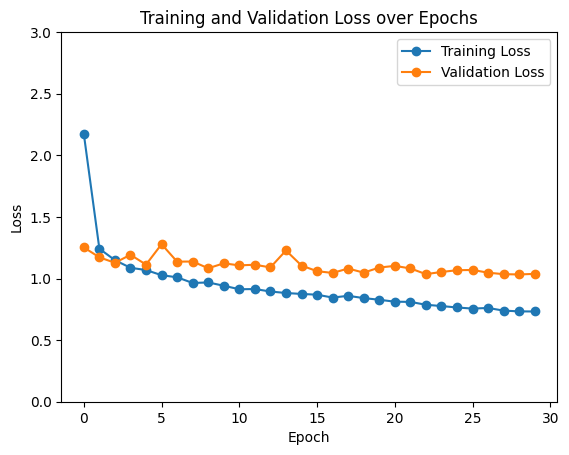

In [ ]:
import matplotlib.pyplot as plt

train_loss = [2.173, 1.242, 1.149, 1.087, 1.069, 1.027, 1.01, 0.9638, 0.9682, 0.9414,
              0.913, 0.9145, 0.8947, 0.8824, 0.8749, 0.8687, 0.8454, 0.8596, 0.8412, 0.8277,
              0.8119, 0.8104, 0.787, 0.7766, 0.7649, 0.756, 0.761, 0.7394, 0.7334, 0.7324]
val_loss = [1.2528, 1.1719, 1.1277, 1.1928, 1.1129, 1.2786, 1.1369, 1.1381, 1.0833, 1.1233,
            1.1067, 1.1119, 1.0903, 1.2275, 1.1054, 1.0595, 1.0454, 1.0811, 1.0477, 1.0891,
            1.1026, 1.0821, 1.0356, 1.0532, 1.0673, 1.0696, 1.0474, 1.0353, 1.0330, 1.0379]

plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()

In [ ]:
from ultralytics.utils.metrics import ConfusionMatrix

In [ ]:
metrics = model.val()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv5n summary (fused): 193 layers, 2503529 parameters, 0 gradients, 7.1 GFLOPs


val: Scanning /content/valid/labels.cache... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 5/10 [00:03<00:03,  1.43it/s]

WARNING ⚠️ NMS time limit 0.900s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


                   all         73        967      0.872      0.899       0.91      0.641
             Platelets         73         76      0.845      0.908      0.891      0.494
                   RBC         73        819      0.804      0.817       0.87      0.628
                   WBC         73         72      0.966      0.972       0.97      0.803
Speed: 0.5ms preprocess, 21.8ms inference, 0.0ms loss, 29.9ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
print(metrics.confusion_matrix.matrix)

[[         72           0           0          26]
 [          0         760           0         455]
 [          1           0          70           1]
 [          3          59           2           0]]


In [ ]:
from IPython.display import Image

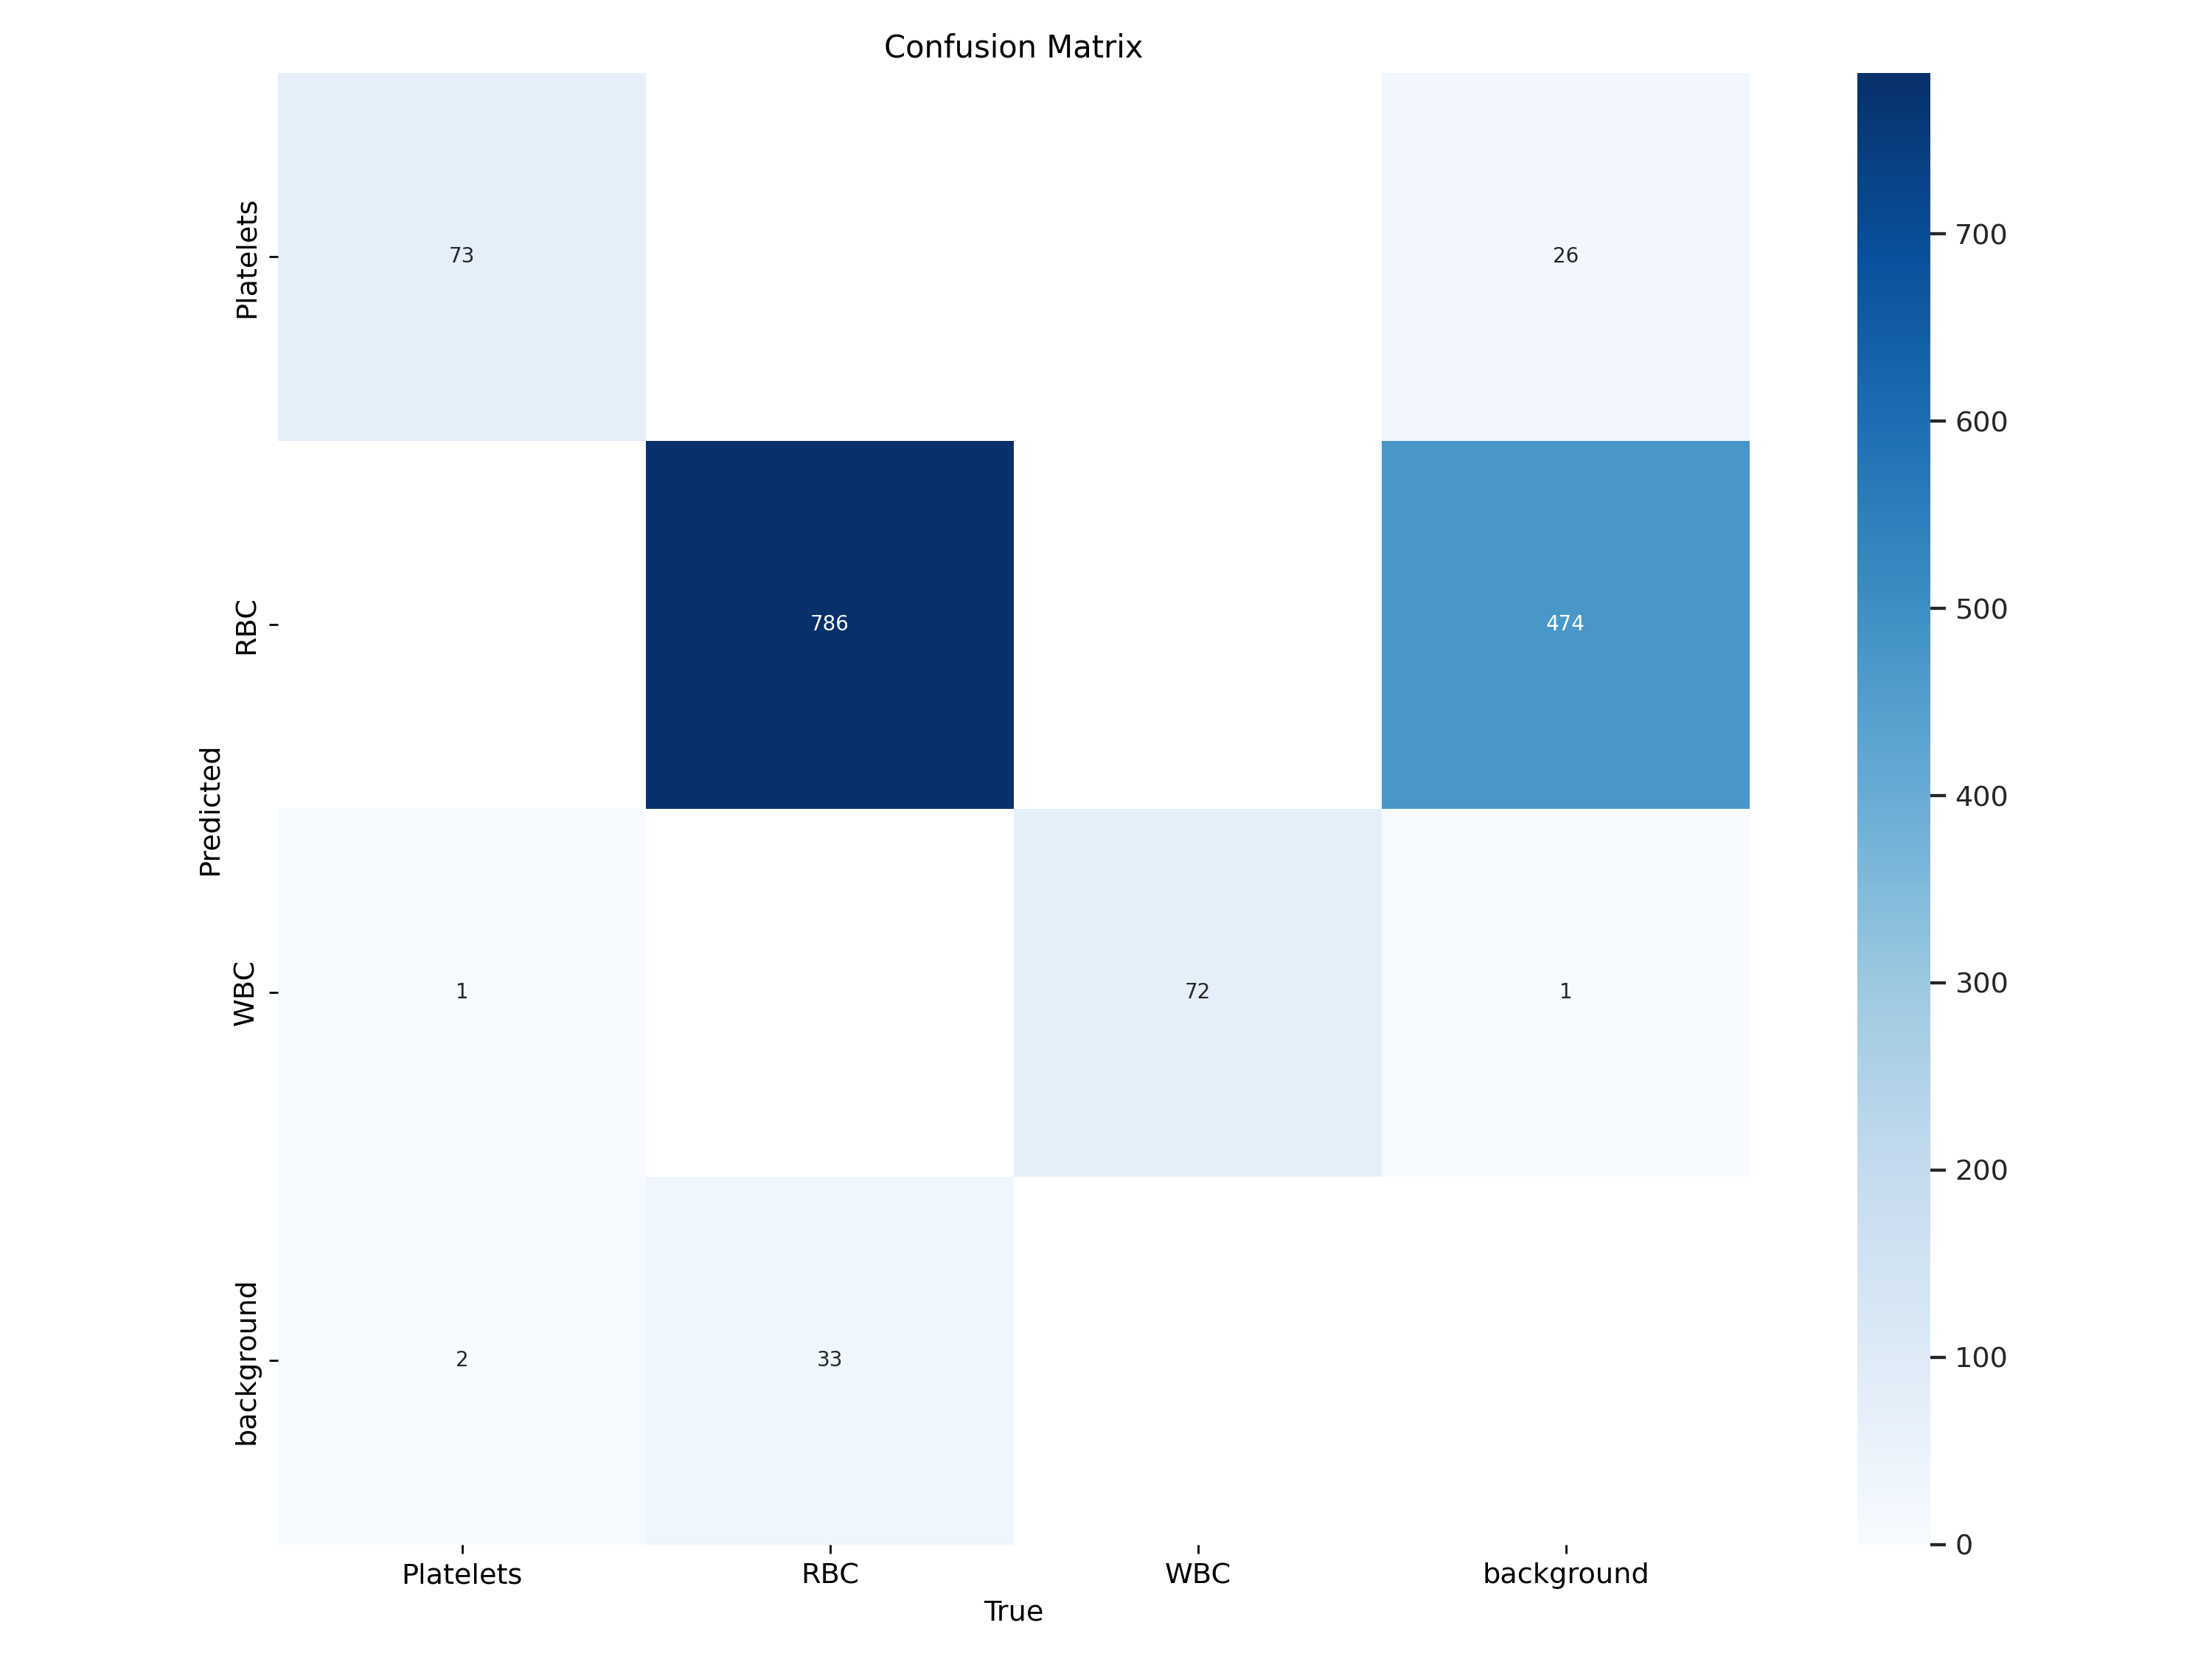

In [ ]:
Image(filename='/content/runs/detect/train/confusion_matrix.png', height=400)

In [ ]:
conf_mat = metrics.confusion_matrix.matrix

# Calculate IoU
iou = np.diag(conf_mat) / (conf_mat.sum(axis=1) + conf_mat.sum(axis=0) - np.diag(conf_mat))

# Calculate Dice coefficient
dice_coefficient = (2 * np.diag(conf_mat)) / (conf_mat.sum(axis=0) + conf_mat.sum(axis=1))

print(f'Test IoU: {np.mean(iou):.4f}')
print(f'Test Dice Coefficient: {np.mean(dice_coefficient):.4f}')

Test IoU: 0.5621
Test Dice Coefficient: 0.6368


In [ ]:
print(metrics.box.map75)

0.7365517121550074


In [ ]:
print(metrics.box.f1)

[    0.87522     0.81013     0.96928]


GROUND TRUTH TRAINING DATA:


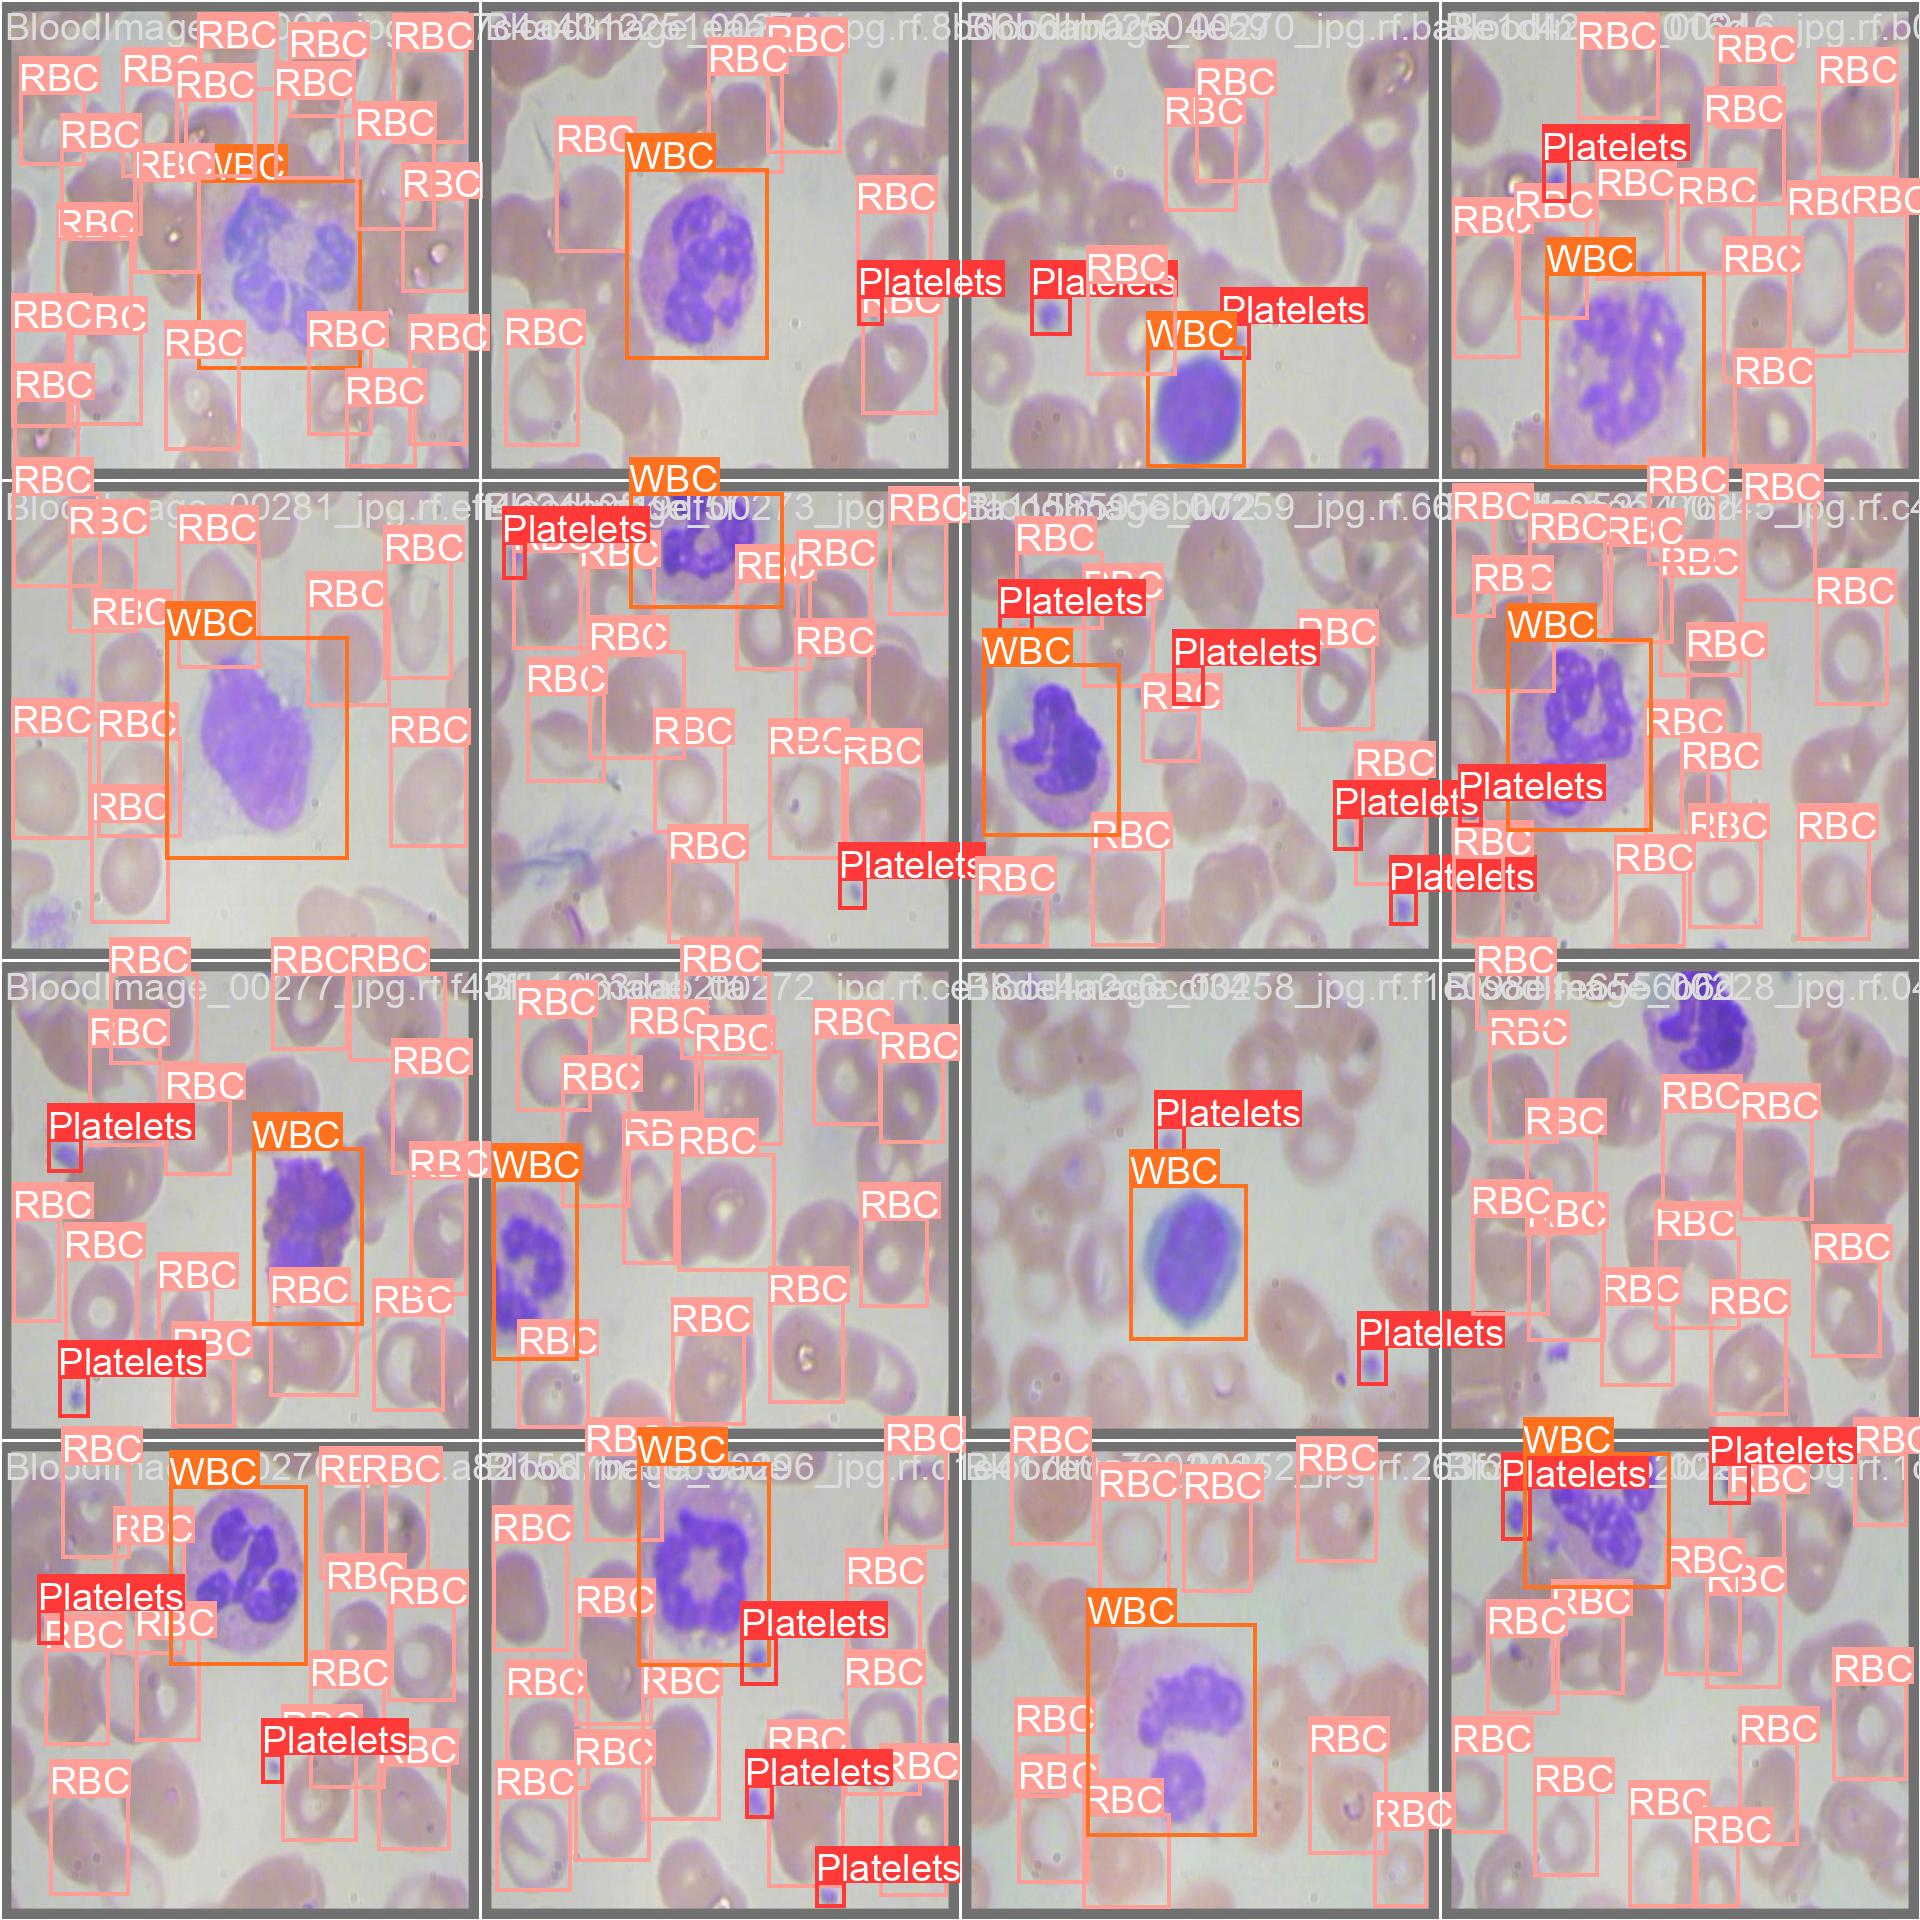

In [ ]:
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/runs/detect/train/val_batch0_labels.jpg', width=900)

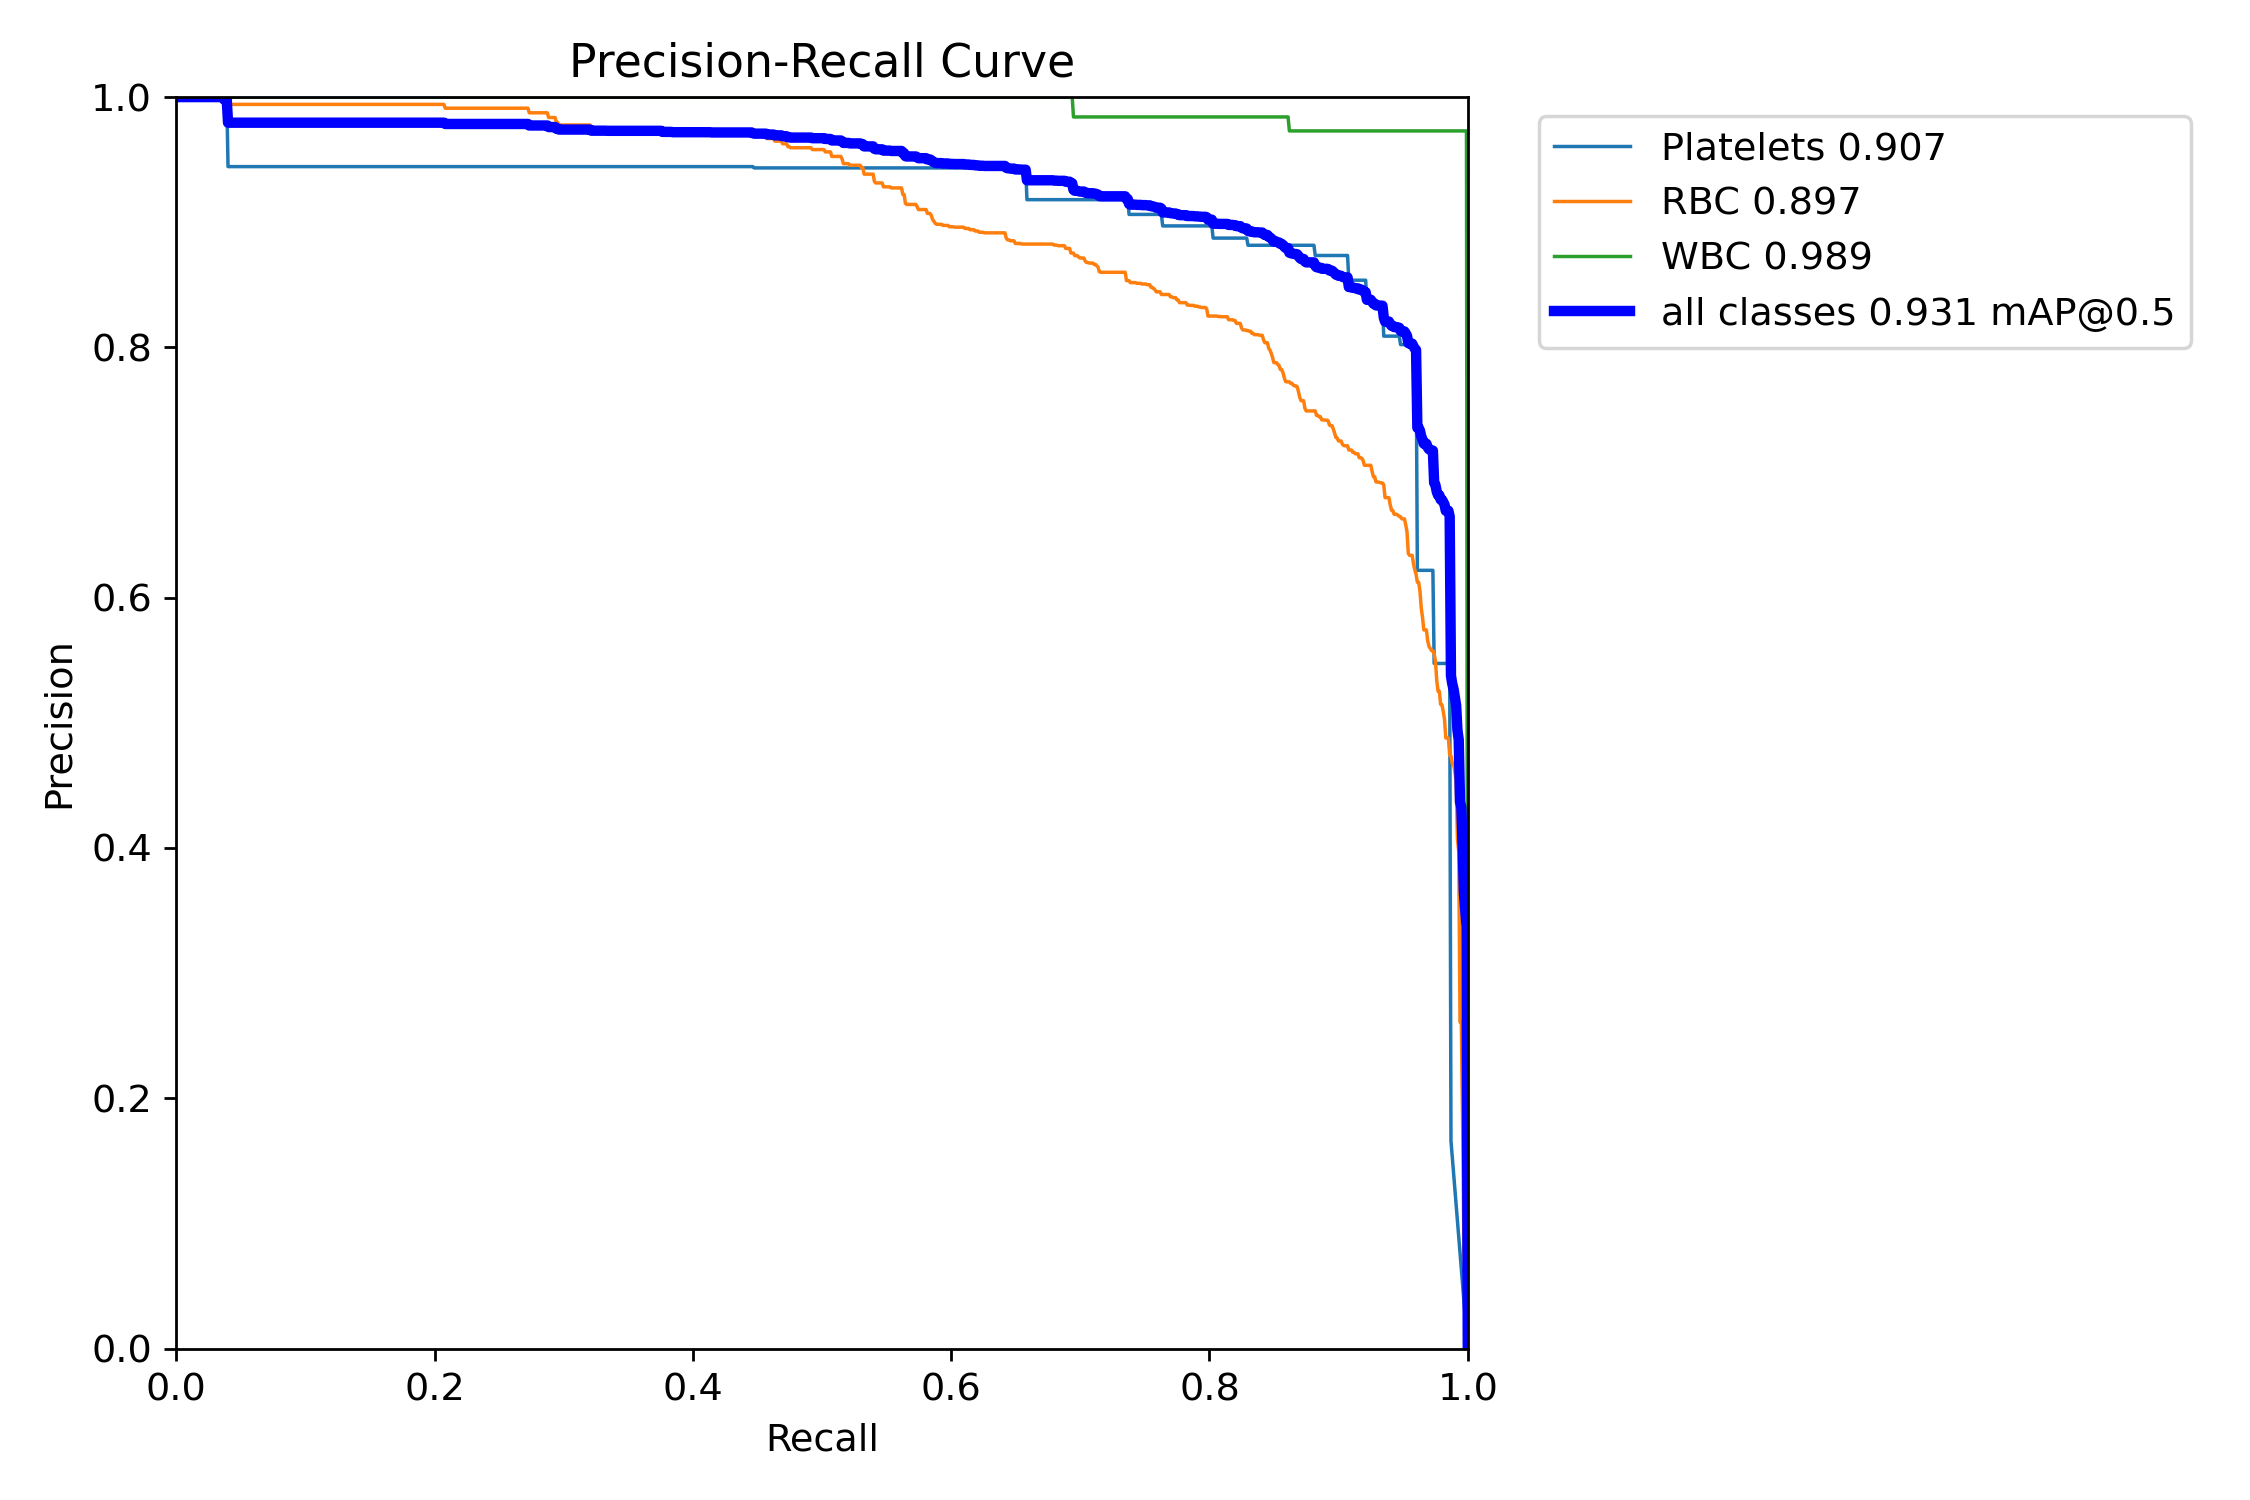

In [ ]:
Image(filename='/content/runs/detect/train/PR_curve.png', height=400)

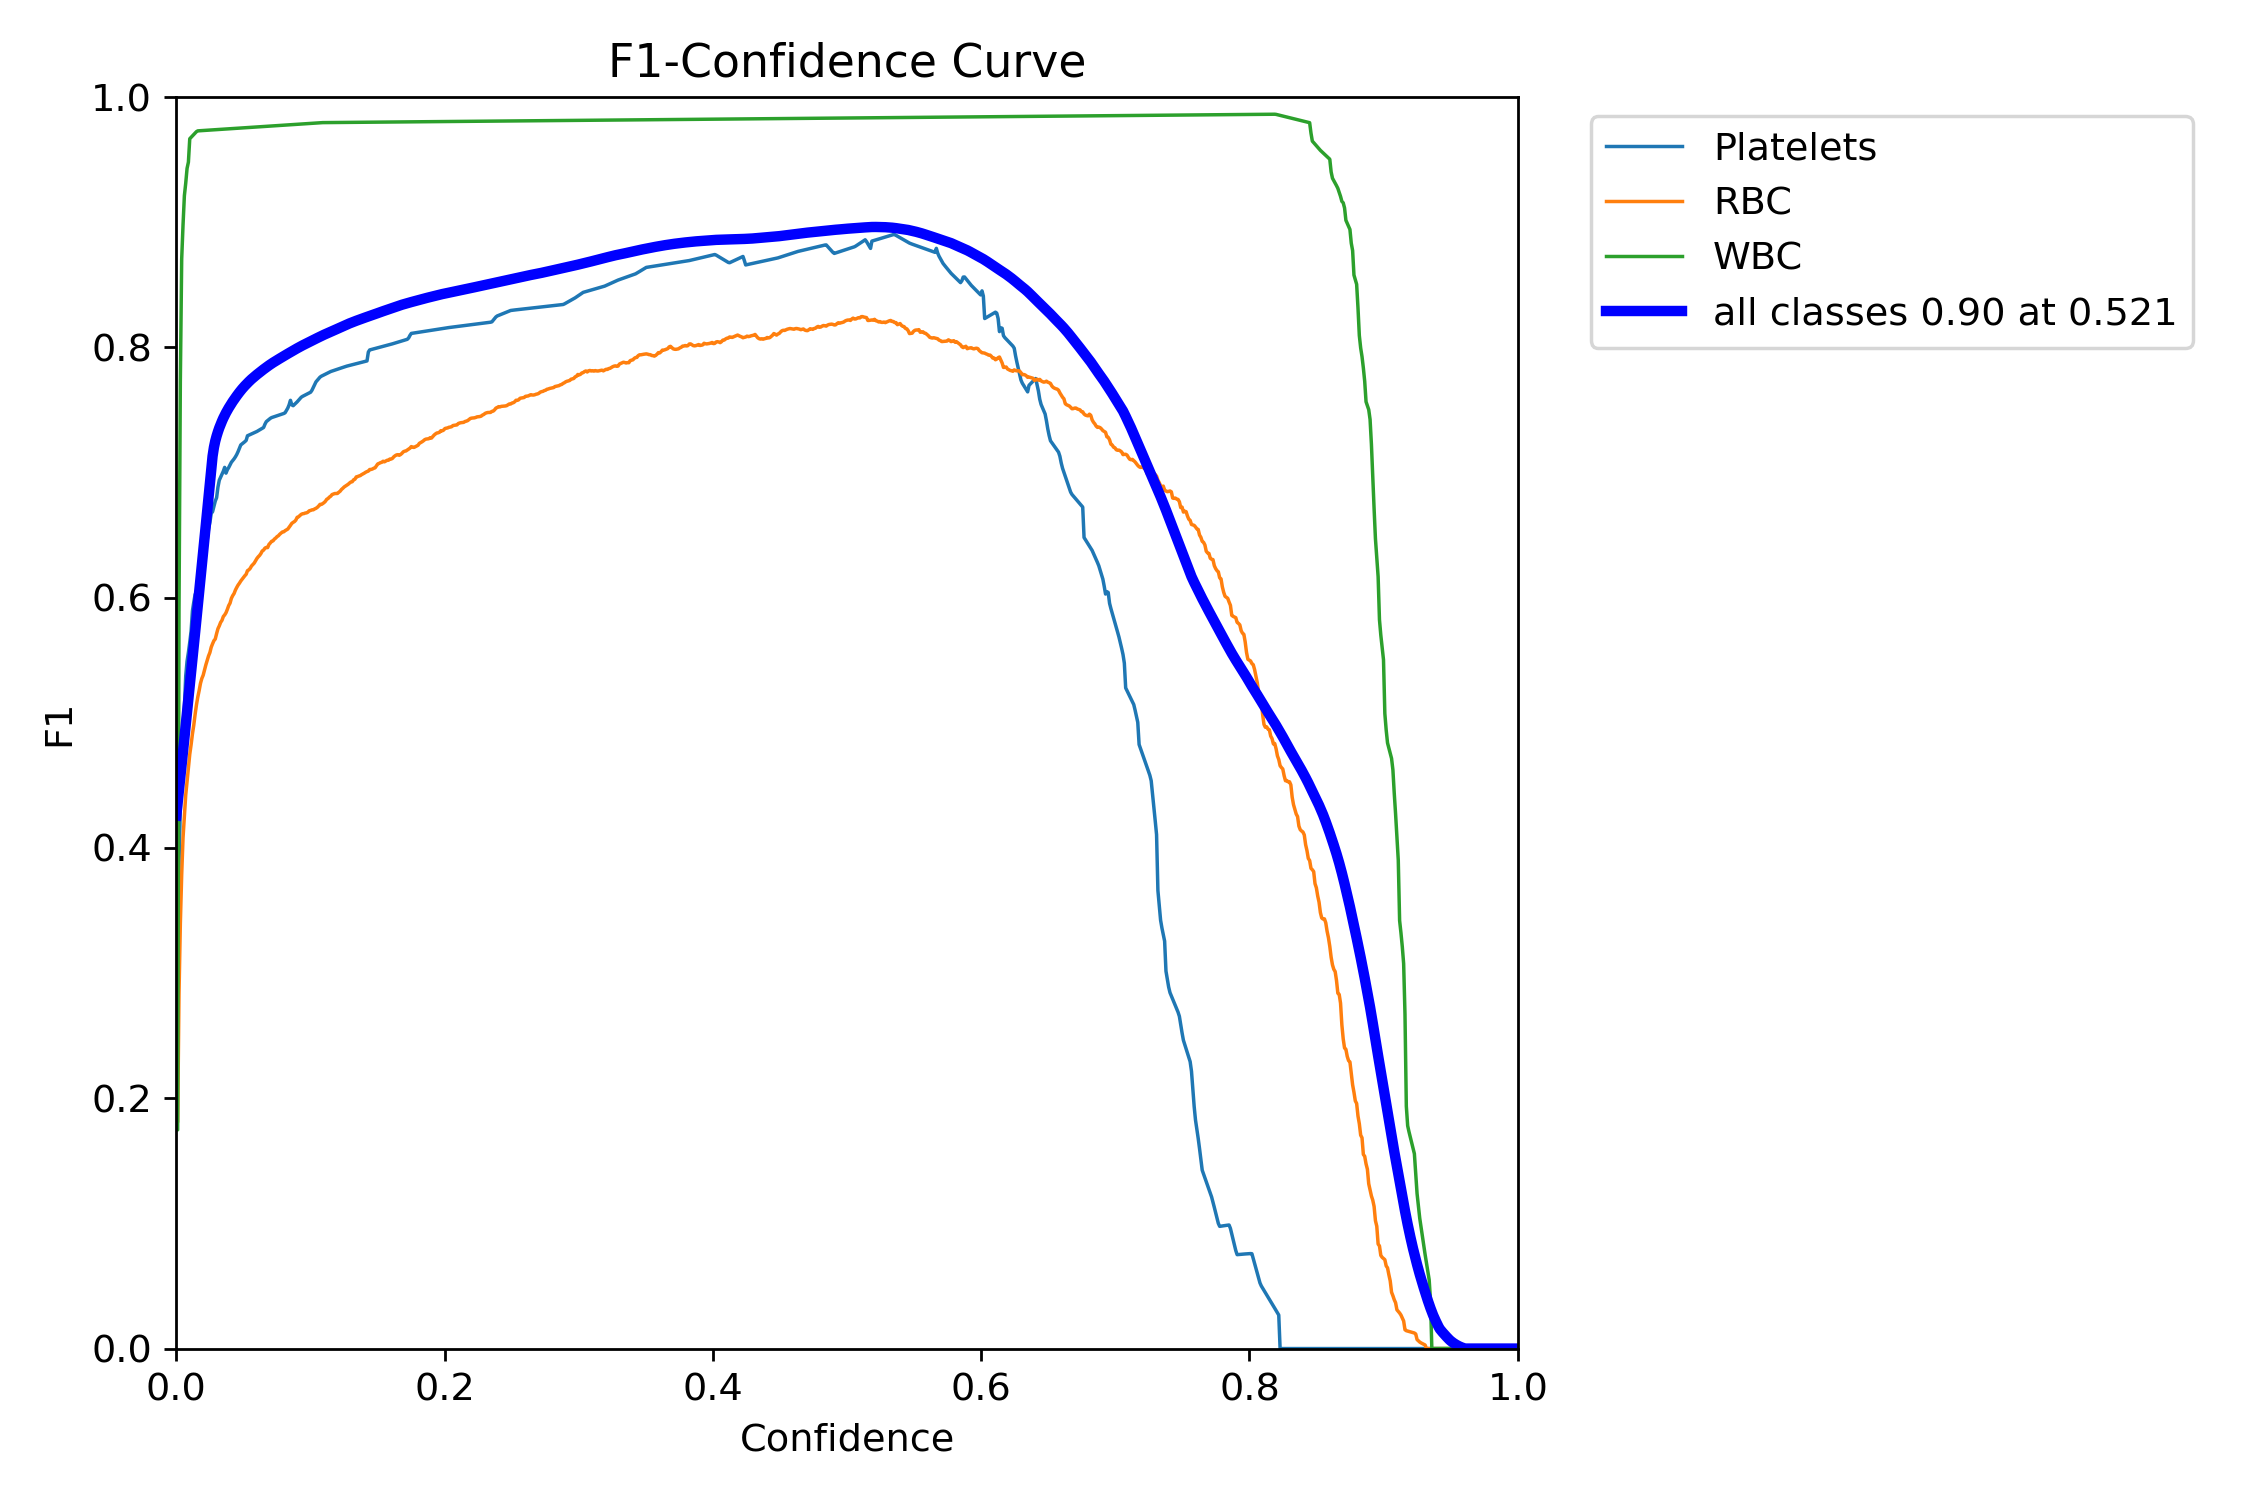

In [ ]:
Image(filename='/content/runs/detect/train/F1_curve.png', height=400)

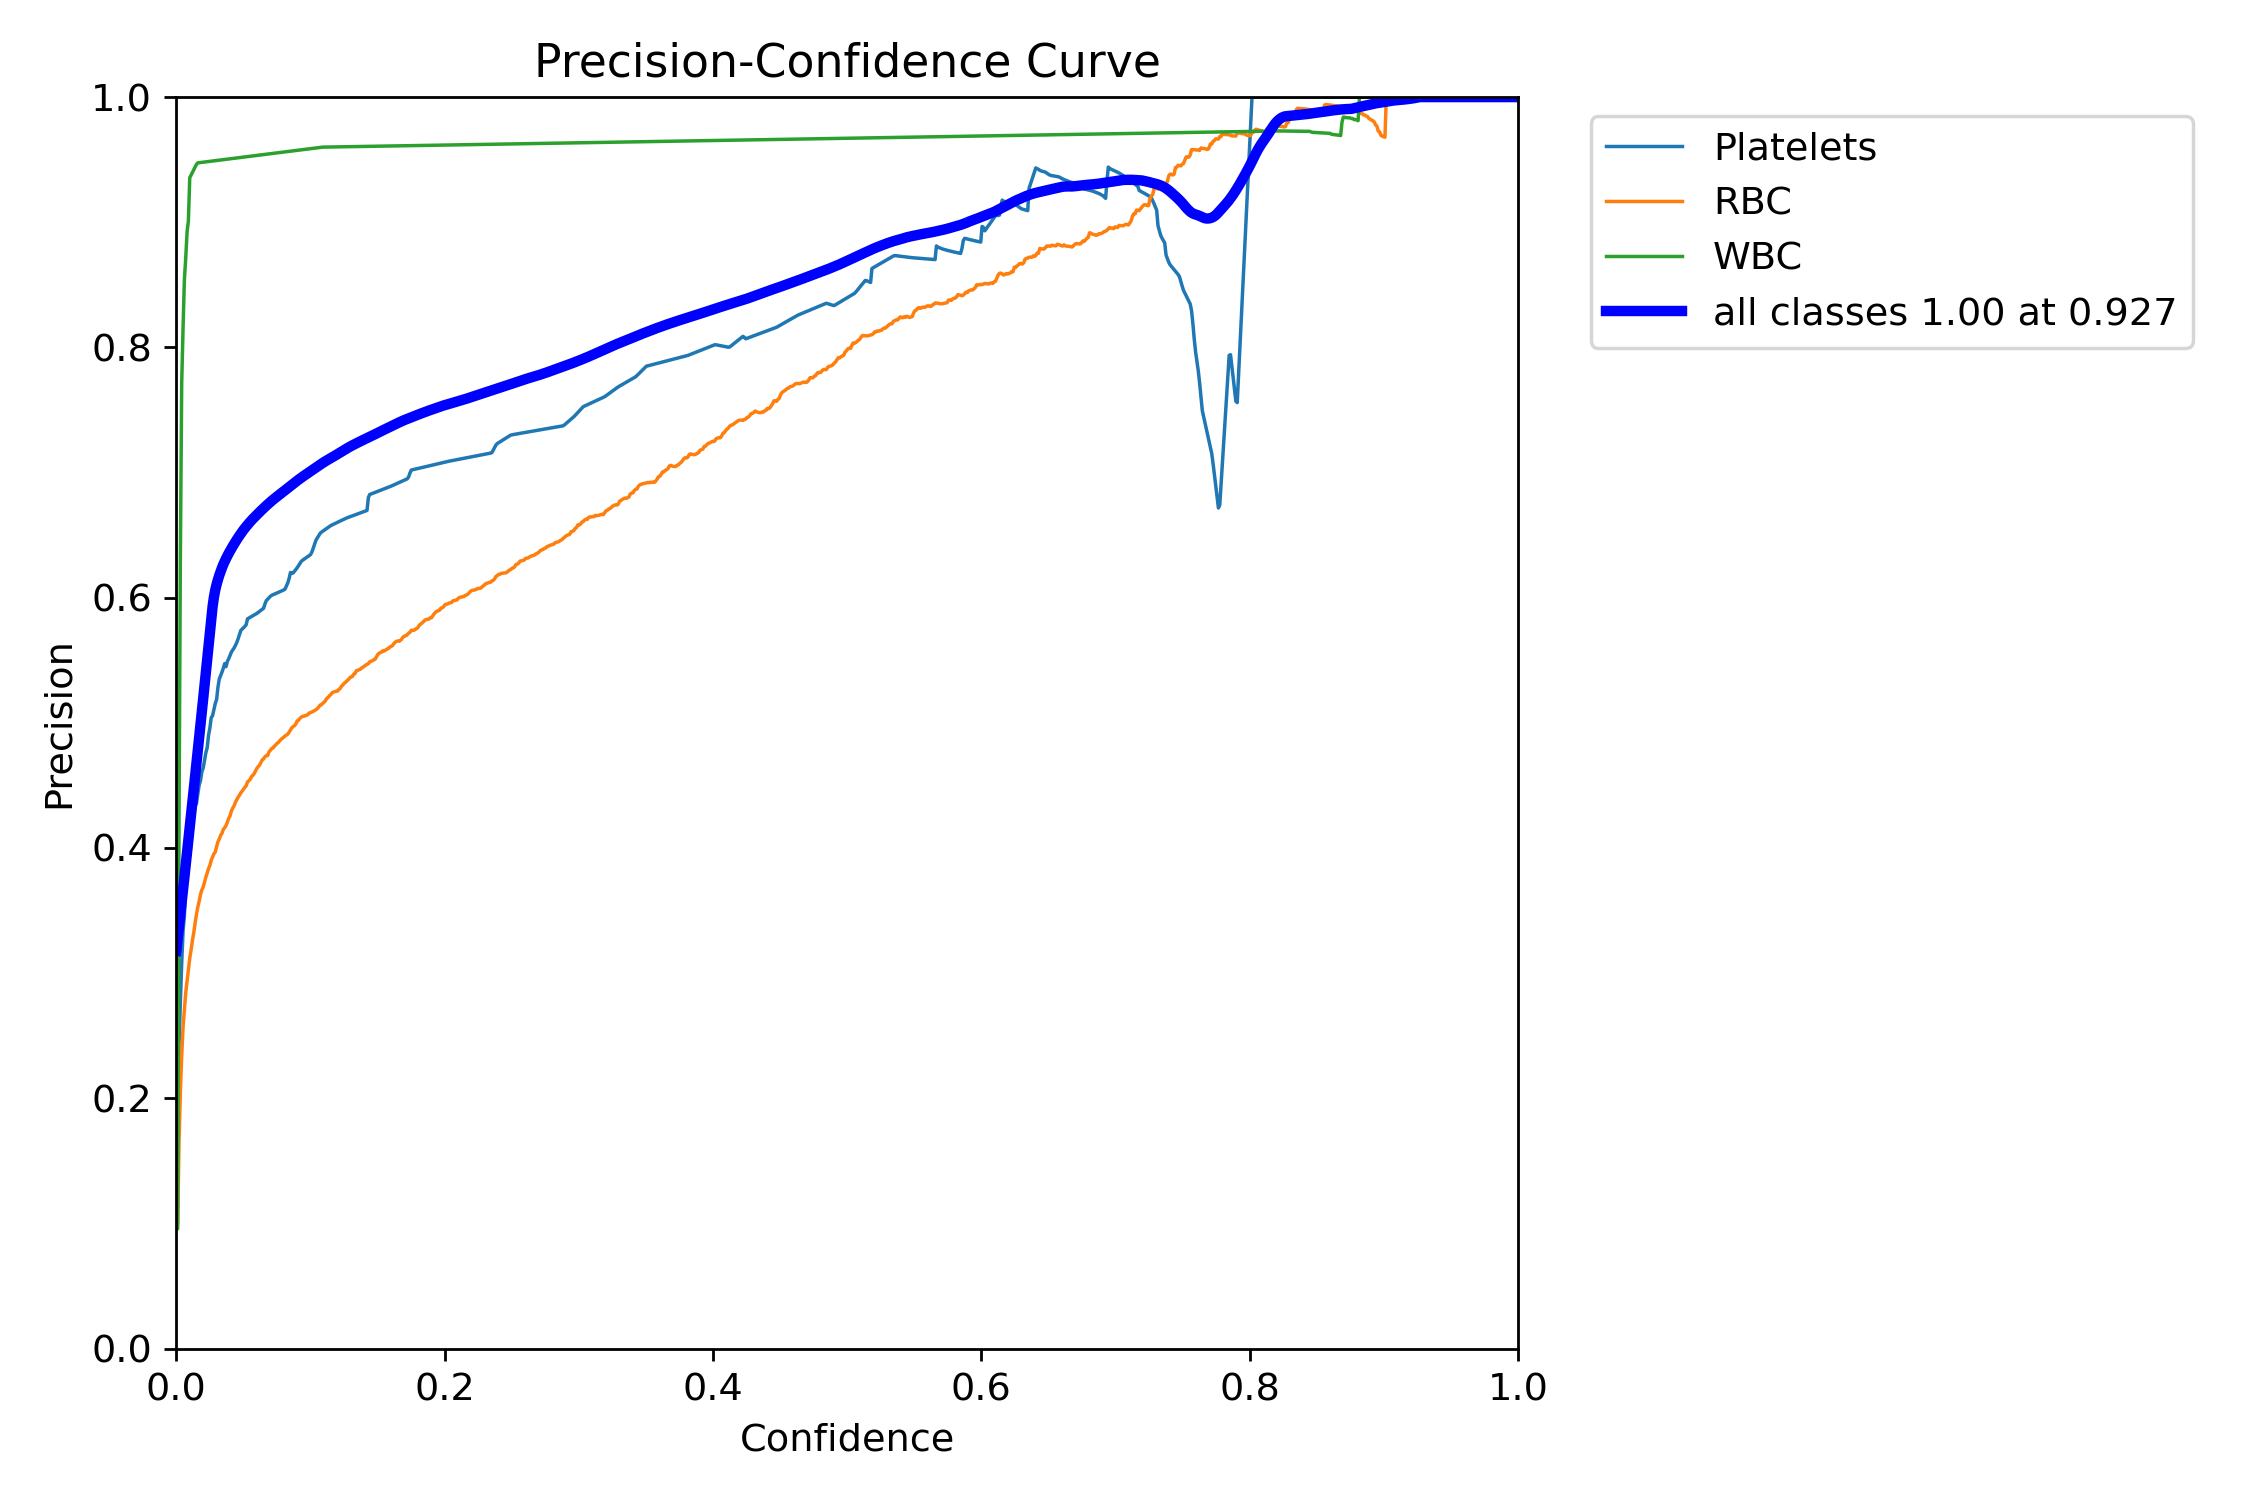

In [ ]:
Image(filename='/content/runs/detect/train/P_curve.png', height=400)

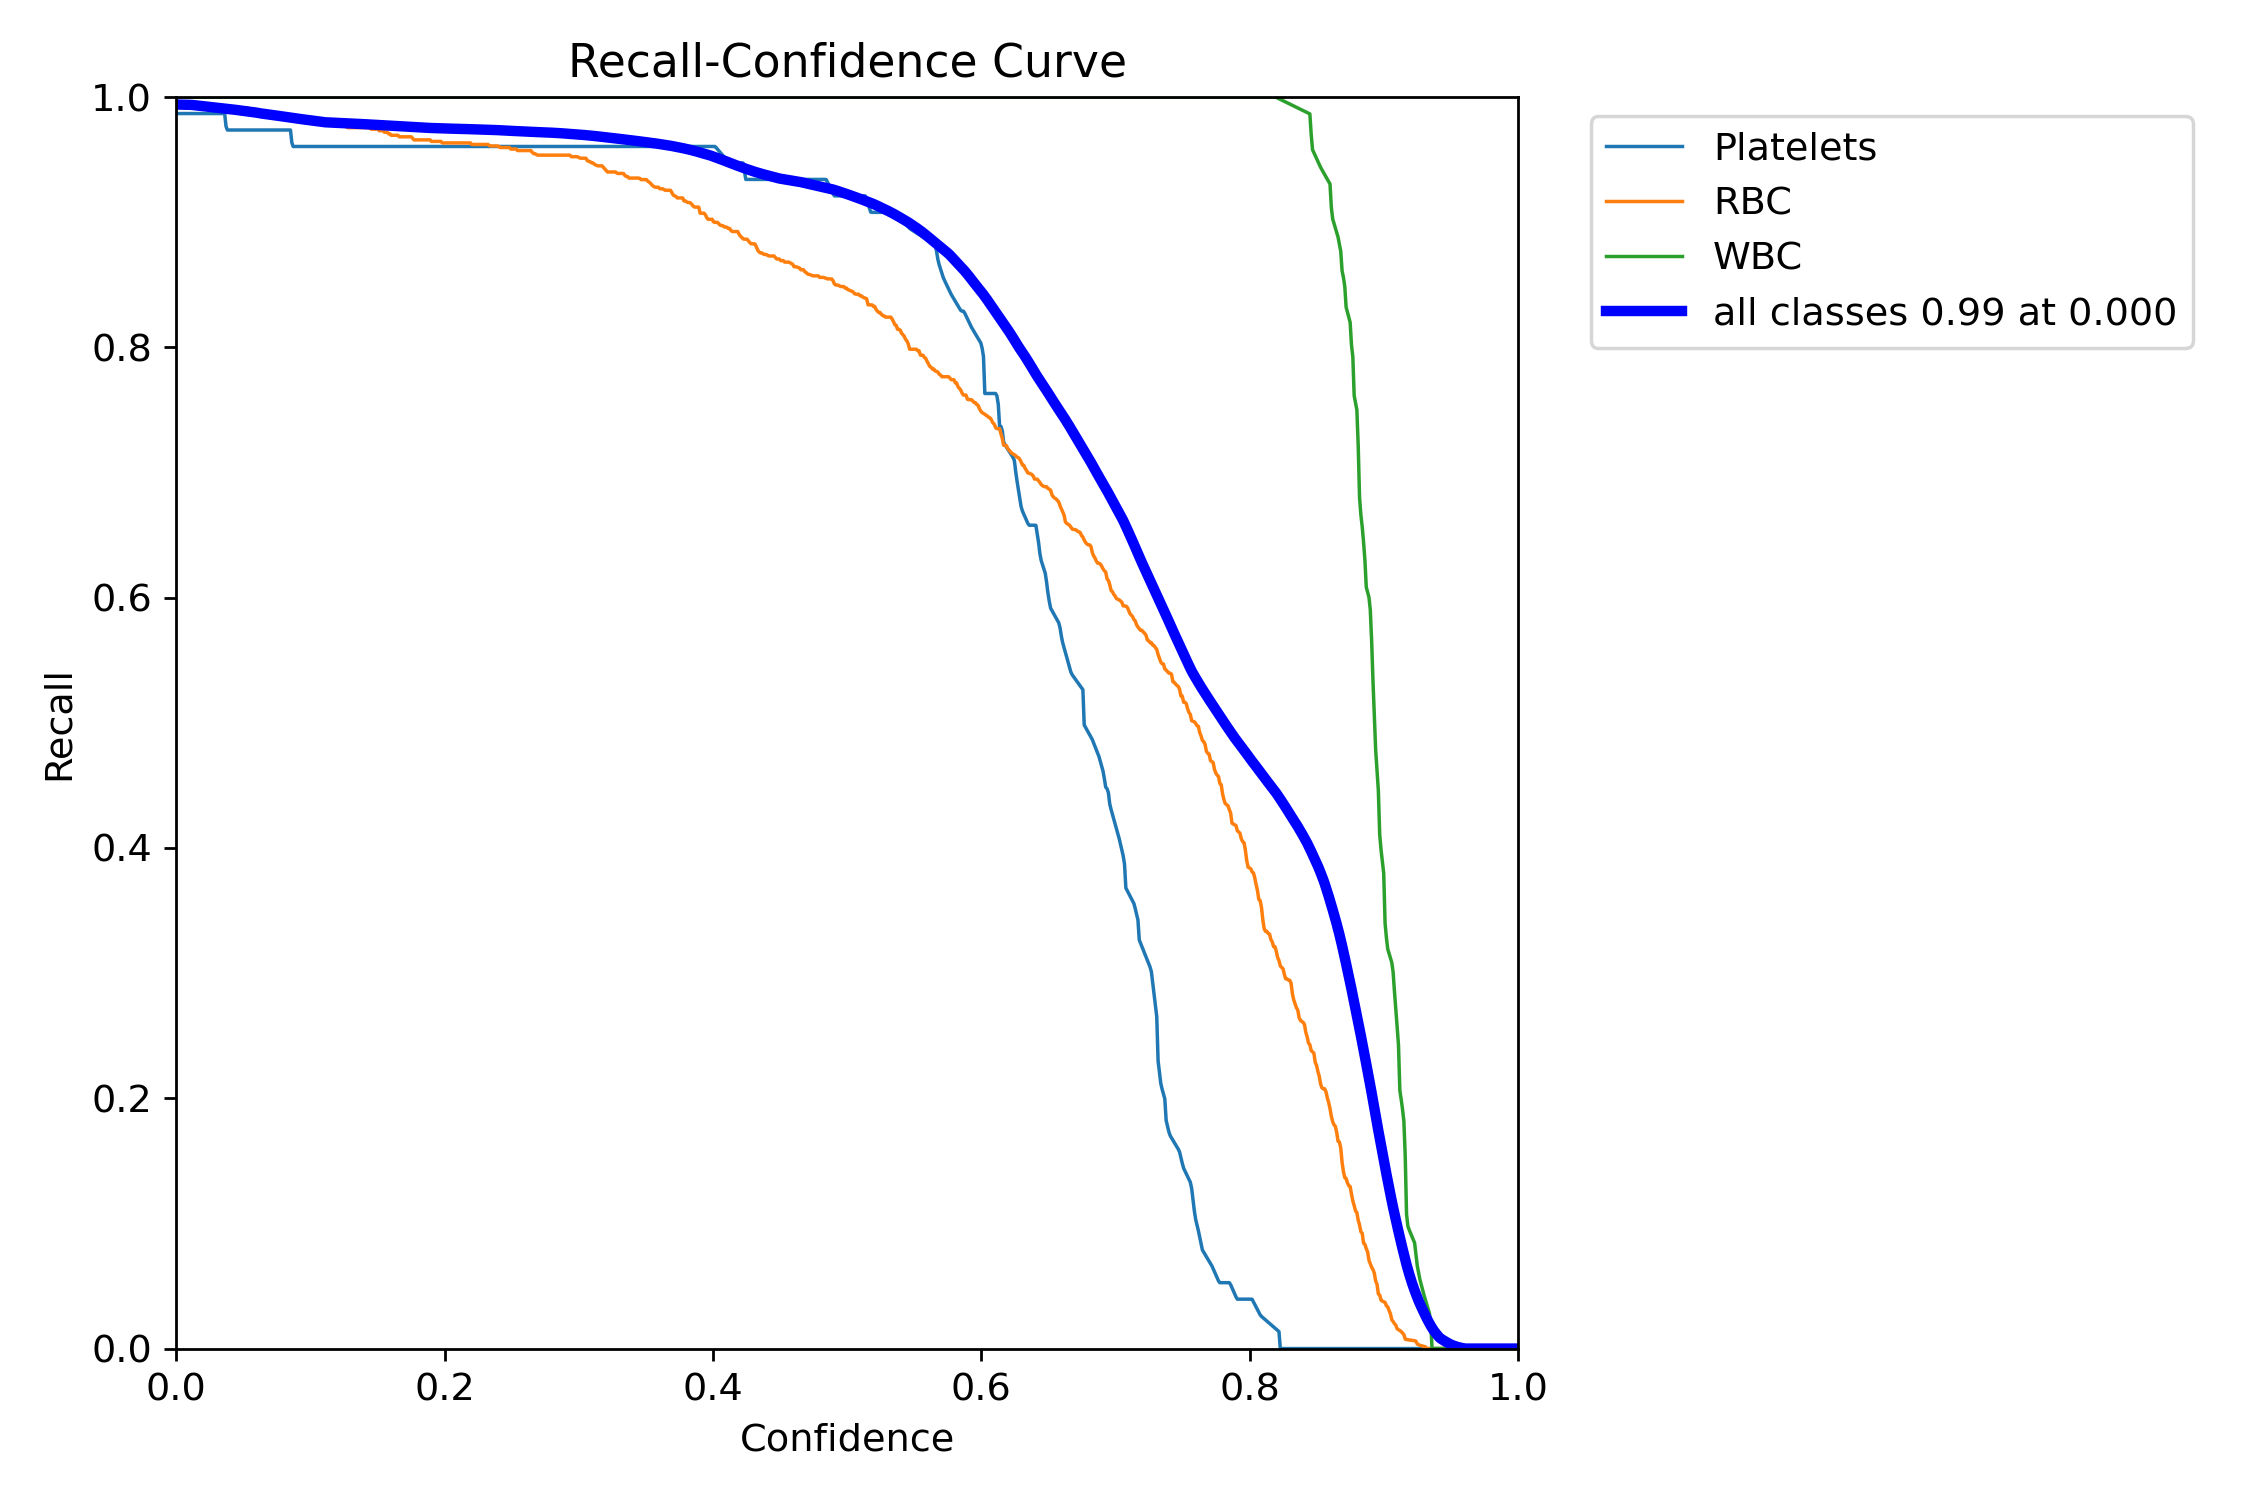

In [ ]:
Image(filename='/content/runs/detect/train/R_curve.png', height=400)

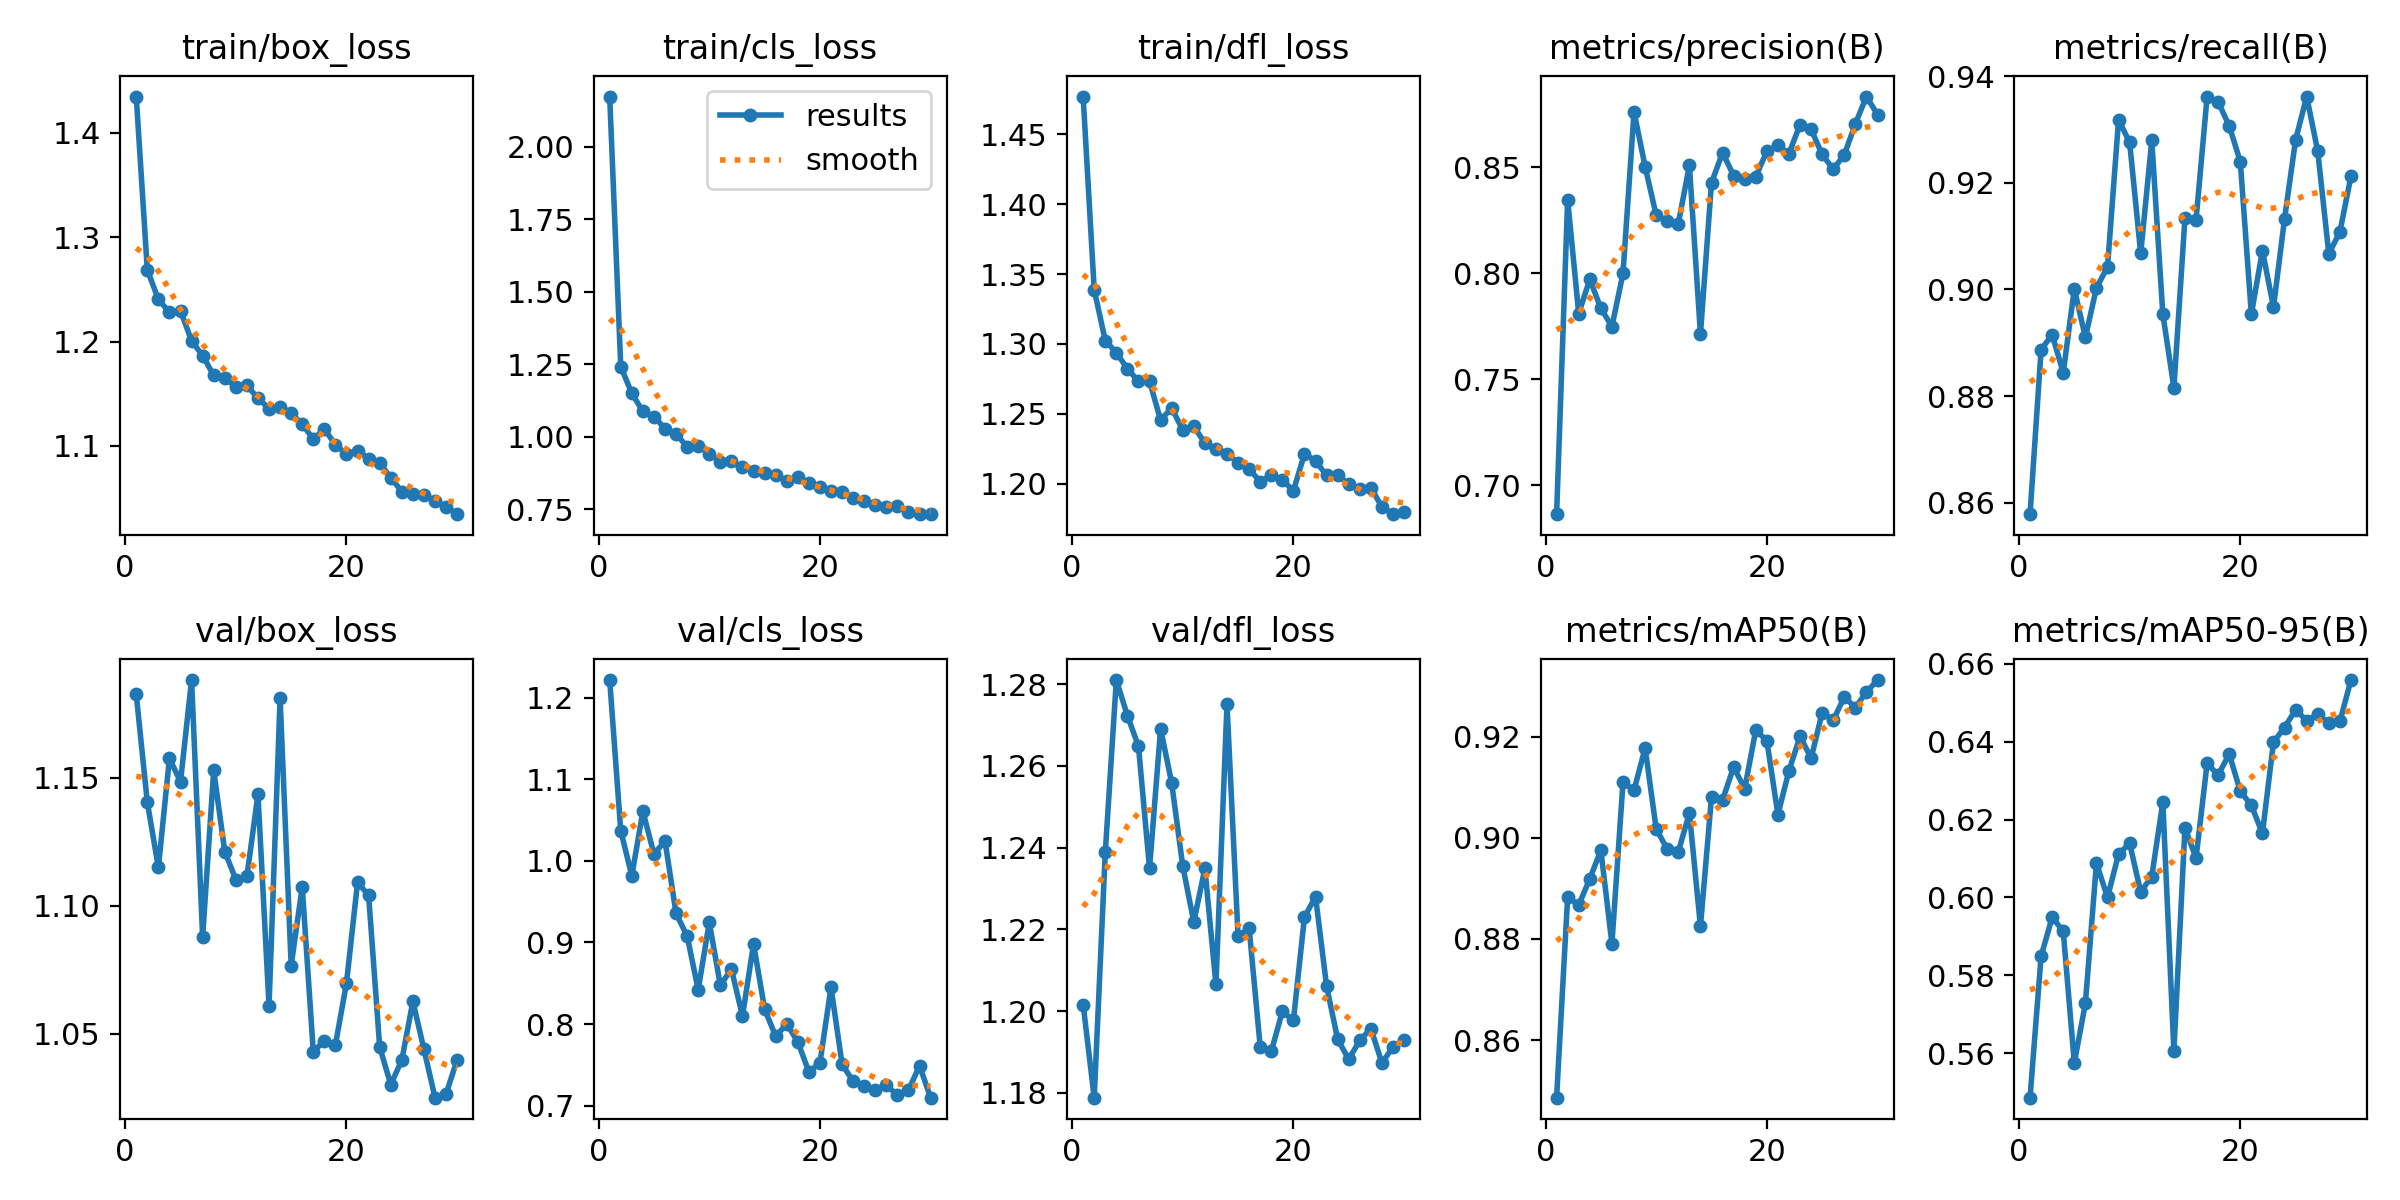

In [ ]:
Image(filename='/content/runs/detect/train/results.png', height=500)

In [ ]:
# results = model.predict(source='/content/test/images', show = True)

WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/36 /content/test/images/BloodImage_00038_jpg.rf.ffa23e4b5b55b523367f332af726eae8.jpg: 640x640 4 Plateletss, 30 RBCs, 1 WBC, 9.1ms
image 2/36 /content/test/images/BloodImage_00044_jpg.rf.e7760375eba4bc20c5746367e2311e18.jpg: 640x640 3 Plateletss, 18 RBCs, 2 WBCs, 8.3ms
image 3/36 /content/test/images/BloodImage_00062_jpg.rf.1be1ca0ecdf783798fc10346baaa203e.jpg: 640x640 6 Plateletss, 18 RBCs, 1 WBC, 8.1ms
image 4/36 /content/test/images/BloodImage_00090_jpg.rf.cdbf8f6ed3b93fa902a0bc991132cb40.jpg: 640x640 5 Plateletss, 23 RBCs, 1 WBC, 8.0ms
image 5/36 /content/test/images/BloodImage_00099_jpg.rf.e3c42cd68359527494a53843479dff5c.jpg: 640x640 3 Plateletss, 21 RBCs, 1 WBC, 8.3ms
image 6/36 /content/test/images/BloodImage_00112_jpg.rf.978cec39235980055c2ad7ff8b6f1912.jpg: 640x640 1 Platelets, 24 RBCs, 1 WBC, 8.1ms
image 7/36 /content/test/images/BloodImage_00113_jpg.rf.a17463f1ddc2e7729f935f8a74bc86a4.jpg: 640

In [ ]:
%cd /content/yolov5/
!python train.py --img 640 --epochs 40 --data '/content/data.yaml' --weights yolov5n.pt

In [ ]:
from IPython.display import Image